# R4 - Siamese Network for Image Similarity Assessment

In this notebook, we'll implement a Siamese neural network for flower image similarity on the 102 Flowers Dataset.

## Project Overview

Building on our exploration of the 102 Flower Category Dataset, we'll now:

1. Prepare the dataset with appropriate preprocessing
2. Implement a dynamic pair generation strategy
3. Create a modular Siamese network architecture with timm backbones
4. Train and evaluate our model on the flower similarity task

Our approach will follow the dynamic pair generation strategy incorporating best practices for Siamese networks.

## Section 1: Environment Setup

First, let's install the necessary packages and import the required libraries.

In [2]:
# Install necessary packages
!pip install torch torchvision timm matplotlib seaborn scikit-learn pandas

In [3]:
# Import necessary libraries
import os
import glob
import time
import random
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

# Import timm for model backbones
import timm

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

# Enable inline plotting
%matplotlib inline

Remember the following candidate models as Siamese network's backbone.

| Model                         | Module       | Top-1   | Param Count (M) | Selection Criteria |
|------------------------------|--------------|---------|------------------|--------------------|
| maxvit_large_tf_224.in1k     | maxxvit      | 84.934  | 211.79           | Top Accuracy       |
| maxvit_base_tf_224.in1k      | maxxvit      | 84.87   | 119.47           | Top Accuracy       |
| maxvit_small_tf_224.in1k     | maxxvit      | 84.456  | 68.93            | Top Accuracy       |
| gcvit_base.in1k              | gcvit        | 84.454  | 90.32            | Top Accuracy       |
| gcvit_small.in1k             | gcvit        | 83.908  | 51.09            | Top Accuracy       |
| tf_mixnet_s.in1k             | efficientnet | 75.652  | 4.13             | High Efficiency    |
| regnety_004.tv2_in1k         | regnet       | 75.588  | 4.34             | High Efficiency    |
| repghostnet_111.in1k         | repghost     | 75.068  | 4.54             | High Efficiency    |
| tf_mixnet_m.in1k             | efficientnet | 76.964  | 5.01             | High Efficiency    |
| tiny_vit_5m_224.in1k         | tiny_vit     | 79.196  | 5.39             | High Efficiency    |
| gcvit_tiny.in1k              | gcvit        | 83.4    | 28.22            | Compact Size       |
| tiny_vit_21m_224.in1k        | tiny_vit     | 83.27   | 21.2             | Compact Size       |
| coat_small.in1k              | coat         | 82.376  | 21.69            | Compact Size       |
| sequencer2d_s.in1k           | sequencer    | 82.336  | 27.65            | Compact Size       |
| coat_lite_small.in1k         | coat         | 82.302  | 19.84            | Compact Size       |


In [4]:
# Set global seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

# Set global configuration
CONFIG = {
    'output_dir': 'output',
    'model_dir': 'model',

    # Training parameters
    'epochs': 20,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,

    # Model parameters
    'backbone': "tiny_vit_5m_224.in1k",
    'embedding_dim': 512,
    'image_size': 224,

    # Training mode (options: 'full_training', 'fine_tuning', 'transfer_learning')
    'training_mode': 'fine_tuning',

    # Other settings
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

print(f"Using device: {CONFIG['device']}")

# Create output directories if they don't exist
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(CONFIG['model_dir'], exist_ok=True)

Using device: cuda


## Section 2: Dataset Loading and Preparation

Now, let's load the data from the previous notebook. If needed, we'll also download and extract the dataset.

In [5]:
# Check if dataset files exist, download if necessary
if not os.path.exists('imagelabels.mat') or not os.path.exists('setid.mat'):
    print("Downloading dataset files...")

    if not os.path.exists('102flowers.tgz'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

    if not os.path.exists('imagelabels.mat'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

    if not os.path.exists('setid.mat'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat

    if not os.path.exists('jpg'):
        !tar -xzf 102flowers.tgz

    print("Download and extraction complete.")
else:
    print("Dataset files already exist.")

--2025-07-18 23:11:26--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-07-18 23:11:27--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  15.7MB/s    in 22s     

2025-07-18 23:11:50 (15.2 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2025-07-18 23:11:50--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels

In [6]:
# Helper function to load MAT files with fallback
def load_mat(filepath):
    """Load MAT file with fallback to h5py for newer MAT file formats."""
    try:
        from scipy.io import loadmat
        return loadmat(filepath)
    except:
        import h5py
        with h5py.File(filepath, 'r') as f:
            data = {key: value[:] for key, value in f.items()}
        return data

# Load image labels and dataset split information
image_labels = load_mat("imagelabels.mat")
setid = load_mat("setid.mat")

# Extract labels and dataset splits
labels = image_labels["labels"]
train_ids = setid["tstid"].flatten() if "tstid" in setid else setid["tst"].flatten()
validation_ids = setid["valid"].flatten()
test_ids = setid["trnid"].flatten() if "trnid" in setid else setid["trn"].flatten()

print(f"Dataset contains {labels.shape[1]} images with {len(np.unique(labels))} classes")
print(f"Train set: {len(train_ids)} images")
print(f"Validation set: {len(validation_ids)} images")
print(f"Test set: {len(test_ids)} images")

Dataset contains 8189 images with 102 classes
Train set: 6149 images
Validation set: 1020 images
Test set: 1020 images


In [9]:
# Get list of all image files and associate them with labels
image_dir = Path("jpg")
image_paths = sorted(list(image_dir.glob('image_*.jpg')),
                    key=lambda x: int(x.stem.split('_')[1]))

print(f"Found {len(image_paths)} image files")

# Create a mapping from image paths to labels and dataset splits
image_info = []

for img_path in image_paths:
    img_id = int(img_path.stem.split('_')[1])

    if img_id <= len(labels[0]):  # Make sure we have a label for this image
        label = labels[0, img_id-1]  # -1 because indices are 1-based in the dataset

        # Determine which set this image belongs to
        if img_id in train_ids:
            dataset_split = 'train'
        elif img_id in validation_ids:
            dataset_split = 'validation'
        elif img_id in test_ids:
            dataset_split = 'test'
        else:
            dataset_split = 'unknown'

        image_info.append({
            'image_id': img_id,
            'path': str(img_path),
            'label': int(label),
            'split': dataset_split
        })

# Convert to DataFrame for easier processing
image_df = pd.DataFrame(image_info)

# Show summary of the dataset
print("\nImage distribution by split:")
print(image_df['split'].value_counts())

print("\nClass distribution:")
print(f"Number of classes: {len(image_df['label'].unique())}")
print(f"Min samples per class: {image_df['label'].value_counts().min()}")
print(f"Max samples per class: {image_df['label'].value_counts().max()}")
print(f"Mean samples per class: {image_df['label'].value_counts().mean():.2f}")

Found 8189 image files

Image distribution by split:
split
train         6149
validation    1020
test          1020
Name: count, dtype: int64

Class distribution:
Number of classes: 102
Min samples per class: 40
Max samples per class: 258
Mean samples per class: 80.28


## Section 3: Implement Dynamic Pair Dataset

Now, we'll implement a PyTorch Dataset class that dynamically generates positive and negative pairs for training the Siamese network. This approach avoids the need to precompute and store all possible pairs.

In [10]:
class SiameseDataset(Dataset):
    """
    A dataset that dynamically generates positive and negative pairs for Siamese network training.
    """
    def __init__(self, df, split='train', transform=None, shuffle_pairs=True):
        """
        Initialize the dataset.

        Args:
            df: DataFrame containing image information
            split: Dataset split to use ('train', 'validation', or 'test')
            transform: Transformations to apply to images
            shuffle_pairs: Whether to shuffle the pairs (True for training, False for validation/testing)
        """
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform
        self.shuffle_pairs = shuffle_pairs

        # Group images by class for efficient pair generation
        self.class_indices = {}
        for idx, row in self.df.iterrows():
            label = row['label']
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)

        print(f"{split} set: {len(self.df)} images, {len(self.class_indices)} classes")

        # Create list of indices for the first image in each pair
        self.indices1 = list(range(len(self.df)))
        self.create_pairs()

    def create_pairs(self):
        """
        Creates pairs of indices dynamically based on whether shuffle_pairs is True or False.
        Sets random seed for reproducibility if not shuffling.
        """
        if self.shuffle_pairs:
            # For training: use current time as seed for randomness
            np.random.seed(int(time.time()))
            np.random.shuffle(self.indices1)
        else:
            # For validation/testing: use fixed seed for deterministic pairs
            np.random.seed(42)

        # Decide whether each pair should be positive (same class) or negative (different class)
        # Roughly 50% positive, 50% negative
        select_pos_pair = np.random.rand(len(self.indices1)) < 0.5

        # Create second image indices
        self.indices2 = []

        for i, pos in zip(self.indices1, select_pos_pair):
            class1 = self.df.iloc[i]['label']

            if pos:
                # Positive pair (same class)
                # Get all indices for this class except the current one
                same_class_indices = [idx for idx in self.class_indices[class1] if idx != i]

                if same_class_indices:
                    # Randomly select another image from the same class
                    idx2 = np.random.choice(same_class_indices)
                else:
                    # If no other images in this class, use the same image
                    idx2 = i
            else:
                # Negative pair (different class)
                # Get a random different class
                other_classes = list(set(self.class_indices.keys()) - {class1})
                class2 = np.random.choice(other_classes)

                # Select a random image from that class
                idx2 = np.random.choice(self.class_indices[class2])

            self.indices2.append(idx2)

        self.indices2 = np.array(self.indices2)

    def __len__(self):
        return len(self.indices1)

    def __getitem__(self, idx):
        """
        Get a pair of images with their similarity label.

        Returns:
            (img1, img2): Tuple of two image tensors
            target: Binary label (1 for same class, 0 for different class)
            (class1, class2): Classes of the two images (for analysis)
        """
        idx1 = self.indices1[idx]
        idx2 = self.indices2[idx]

        # Get image paths and classes
        img1_path = self.df.iloc[idx1]['path']
        img2_path = self.df.iloc[idx2]['path']

        class1 = self.df.iloc[idx1]['label']
        class2 = self.df.iloc[idx2]['label']

        # Load images
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        # Apply transformations if specified
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        # Target is 1 if same class, 0 if different
        target = torch.FloatTensor([float(class1 == class2)])

        return (img1, img2), target, (class1, class2)

## Section 4: Data Augmentation and Preprocessing

Next, we'll define our data augmentation and preprocessing pipelines for training and validation/testing. Good augmentation strategies are crucial for Siamese networks to learn robust feature representations.

In [12]:
# Define data transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'] + 32, CONFIG['image_size'] + 32)),
    transforms.RandomCrop(CONFIG['image_size']),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Define data transformations for validation and testing (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Create dataset instances
train_dataset = SiameseDataset(image_df, split='train', transform=train_transform, shuffle_pairs=True)
val_dataset = SiameseDataset(image_df, split='validation', transform=val_transform, shuffle_pairs=False)
test_dataset = SiameseDataset(image_df, split='test', transform=val_transform, shuffle_pairs=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

train set: 6149 images, 102 classes
validation set: 1020 images, 102 classes
test set: 1020 images, 102 classes
Train batches: 192
Validation batches: 32
Test batches: 32


Sample training pairs:


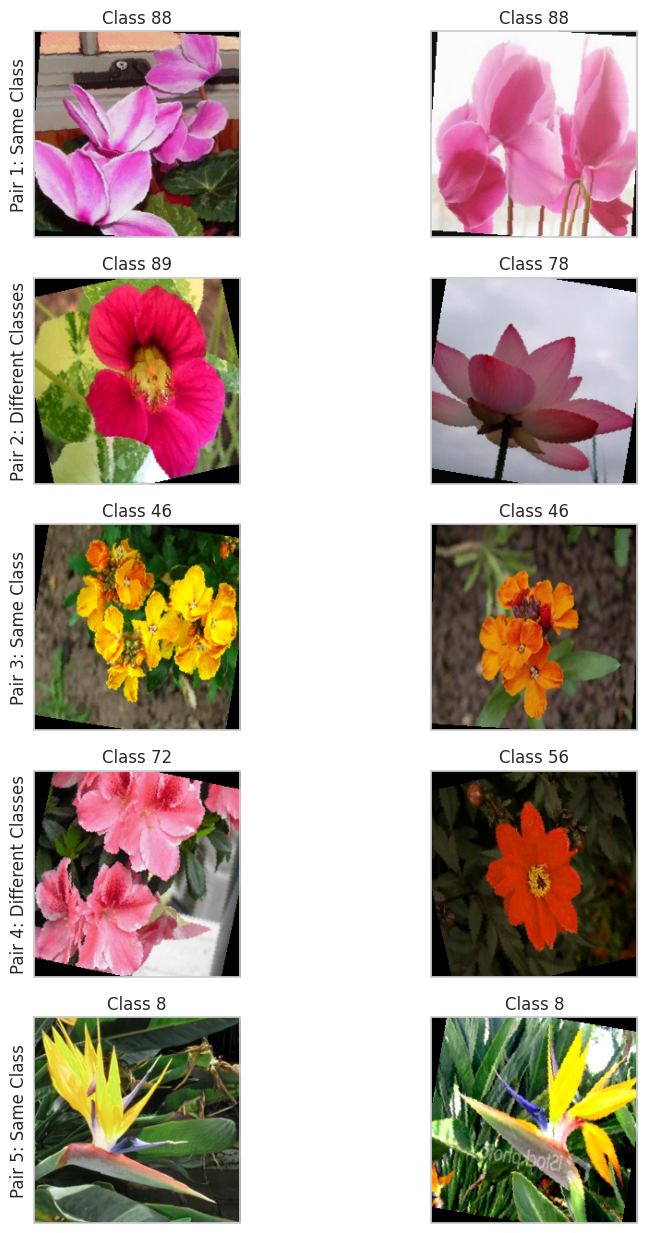


Sample validation pairs:


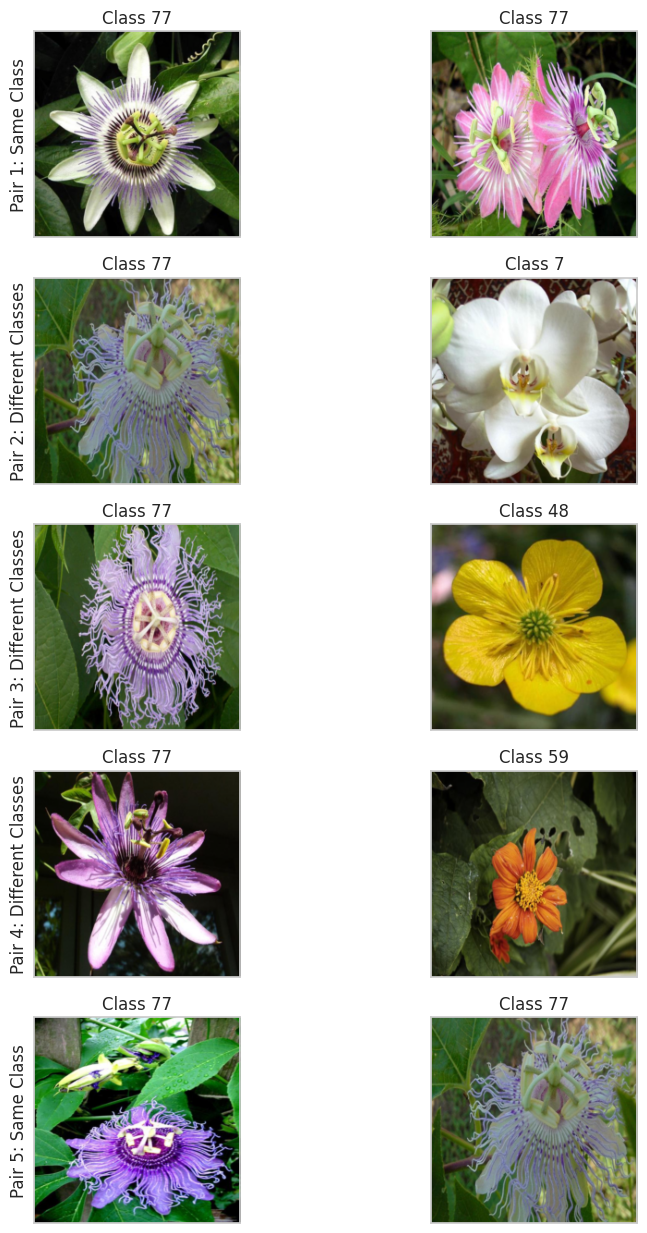

In [13]:
# Function to visualize sample pairs from the dataset
def visualize_pairs(dataloader, num_samples=5):
    """
    Visualize sample pairs from the dataloader with their similarity labels.

    Args:
        dataloader: DataLoader to sample from
        num_samples: Number of pairs to display
    """
    # Get a batch of samples
    (images1, images2), targets, (classes1, classes2) = next(iter(dataloader))

    # Only show the first num_samples
    images1 = images1[:num_samples]
    images2 = images2[:num_samples]
    targets = targets[:num_samples]
    classes1 = classes1[:num_samples]
    classes2 = classes2[:num_samples]

    # Create a figure to display the pairs
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2.5*num_samples))

    # Inverse normalization function to convert tensors back to images
    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])
    ])

    # Display each pair
    for i in range(num_samples):
        # Convert tensors to images
        img1 = inv_normalize(images1[i]).permute(1, 2, 0).cpu().numpy().clip(0, 1)
        img2 = inv_normalize(images2[i]).permute(1, 2, 0).cpu().numpy().clip(0, 1)

        # Display images
        axes[i, 0].imshow(img1)
        axes[i, 1].imshow(img2)

        # Set titles
        similarity = "Same Class" if targets[i].item() > 0.5 else "Different Classes"
        axes[i, 0].set_title(f"Class {classes1[i]}")
        axes[i, 1].set_title(f"Class {classes2[i]}")

        # Add label above the pair
        axes[i, 0].set_ylabel(f"Pair {i+1}: {similarity}", fontsize=12)

        # Remove axis ticks
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

    plt.tight_layout()
    plt.show()

# Visualize some training pairs
print("Sample training pairs:")
visualize_pairs(train_loader, num_samples=5)

# Visualize some validation pairs
print("\nSample validation pairs:")
visualize_pairs(val_loader, num_samples=5)

## Section 5: Siamese Network Architecture

Now we'll implement our Siamese network architecture. The network will consist of:
1. A backbone network (from timm) for feature extraction
2. A feature embedding layer (optional)
3. A similarity head for determining whether the pairs belong to the same class

We'll make the architecture modular so that different backbones can be easily swapped.

In [14]:
class SiameseNetwork(nn.Module):
    """
    Siamese Network architecture for image similarity tasks.
    Uses a shared backbone network to extract features from both images,
    then computes similarity between the extracted features.
    """
    def __init__(self, backbone_name='resnet18', pretrained=True, embedding_dim=None, training_mode='transfer_learning'):
        """
        Initialize the Siamese network.

        Args:
            backbone_name: Name of the backbone network from timm
            pretrained: Whether to use pretrained weights
            embedding_dim: Dimension of the embedding layer (None to skip embedding)
            training_mode: One of 'full_training', 'fine_tuning', 'transfer_learning'
        """
        super(SiameseNetwork, self).__init__()

        # Create backbone network from timm
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )

        # Apply training mode settings
        self.training_mode = training_mode
        self._apply_training_mode()

        # Get the output dimension of the backbone
        # For testing the output dimension, pass a dummy input through the backbone
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, CONFIG['image_size'], CONFIG['image_size'])
            backbone_output_dim = self.backbone(dummy_input).shape[1]

        print(f"Backbone: {backbone_name}, Output dimension: {backbone_output_dim}")
        print(f"Training mode: {training_mode}")

        # Optional embedding layer
        self.embedding_dim = embedding_dim
        if embedding_dim is not None:
            self.embedding = nn.Sequential(
                nn.Linear(backbone_output_dim, embedding_dim),
                nn.BatchNorm1d(embedding_dim),
                nn.ReLU(inplace=True)
            )
            final_dim = embedding_dim
        else:
            self.embedding = nn.Identity()
            final_dim = backbone_output_dim

        # Similarity head
        self.similarity_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(final_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward_one(self, x):
        """Forward pass for a single image"""
        features = self.backbone(x)
        embedding = self.embedding(features)
        return embedding

    def _apply_training_mode(self):
        """Apply the selected training mode to the network"""
        if self.training_mode == 'transfer_learning':
            # Freeze the entire backbone
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Transfer learning mode: backbone frozen, only training embedding and similarity head")

        elif self.training_mode == 'fine_tuning':
            # Freeze early layers, train later layers
            # This is a common approach for fine-tuning
            layers_to_freeze = []

            # Handle different model architectures
            if hasattr(self.backbone, 'stem'):
                # Vision transformer style models often have a stem
                layers_to_freeze.append('stem')

            if hasattr(self.backbone, 'stages') and len(self.backbone.stages) > 2:
                # For models with stages (like RegNet, ConvNext, etc.)
                # Freeze early stages, keep later ones trainable
                early_stages = len(self.backbone.stages) // 2
                for i in range(early_stages):
                    layers_to_freeze.append(f'stages.{i}')

            elif hasattr(self.backbone, 'layer1'):
                # ResNet style models
                layers_to_freeze.extend(['conv1', 'bn1', 'act1', 'maxpool', 'layer1', 'layer2'])

            elif hasattr(self.backbone, 'blocks') and len(self.backbone.blocks) > 4:
                # Vision transformer style with blocks
                block_count = len(self.backbone.blocks)
                blocks_to_freeze = block_count // 2
                for i in range(blocks_to_freeze):
                    layers_to_freeze.append(f'blocks.{i}')

            # Apply freezing
            for name, param in self.backbone.named_parameters():
                param.requires_grad = True  # Default to trainable
                for layer_name in layers_to_freeze:
                    if layer_name in name:
                        param.requires_grad = False
                        break

            print(f"Fine-tuning mode: {len(layers_to_freeze)} early layers/blocks frozen, later layers trainable")

        else:  # full_training
            # Train the entire network
            for param in self.backbone.parameters():
                param.requires_grad = True
            print("Full training mode: all layers trainable")

    def forward(self, img1, img2):
        """
        Forward pass for a pair of images.

        Args:
            img1: First image tensor [B, C, H, W]
            img2: Second image tensor [B, C, H, W]

        Returns:
            similarity: Similarity score between the images [B, 1]
        """
        # Extract features from both images
        feat1 = self.forward_one(img1)
        feat2 = self.forward_one(img2)

        # Compute element-wise product of features
        combined_features = feat1 * feat2

        # Pass through similarity head
        similarity = self.similarity_head(combined_features)

        return similarity

    def get_embedding(self, x):
        """Get embeddings for a batch of images (for visualization)"""
        return self.forward_one(x)

# Initialize the Siamese network
model = SiameseNetwork(
    backbone_name=CONFIG['backbone'],
    pretrained=True,
    embedding_dim=CONFIG['embedding_dim']
)

# Move model to device
model = model.to(CONFIG['device'])

# Print model summary
print(f"Initialized Siamese network with {CONFIG['backbone']} backbone")
print(f"Feature embedding dimension: {CONFIG['embedding_dim']}")

model.safetensors:   0%|          | 0.00/21.6M [00:00<?, ?B/s]

Transfer learning mode: backbone frozen, only training embedding and similarity head
Backbone: tiny_vit_5m_224.in1k, Output dimension: 320
Training mode: transfer_learning
Initialized Siamese network with tiny_vit_5m_224.in1k backbone
Feature embedding dimension: 512


## Section 6: Loss Functions, Optimizer, and Metrics

Next, we'll define our loss function, optimizer, and evaluation metrics for training and evaluating the Siamese network.

In [15]:
# Define loss function
criterion = nn.BCELoss()

# Define optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

# Function to compute accuracy
def compute_accuracy(outputs, targets, threshold=0.5):
    """
    Compute binary classification accuracy.

    Args:
        outputs: Model predictions (similarity scores)
        targets: Ground truth labels
        threshold: Classification threshold

    Returns:
        accuracy: Classification accuracy
    """
    predicted = (outputs >= threshold).float()
    correct = (predicted == targets).float().sum()
    accuracy = correct / targets.size(0)
    return accuracy.item()

# Function to compute ROC-AUC score
def compute_roc_auc(all_outputs, all_targets):
    """
    Compute ROC-AUC score.

    Args:
        all_outputs: All model predictions concatenated
        all_targets: All ground truth labels concatenated

    Returns:
        roc_auc: ROC-AUC score
    """
    try:
        # Convert to numpy arrays
        outputs_np = all_outputs.cpu().numpy()
        targets_np = all_targets.cpu().numpy()

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(targets_np, outputs_np)
        roc_auc = auc(fpr, tpr)

        return roc_auc
    except Exception as e:
        print(f"Error computing ROC-AUC: {e}")
        return 0.0

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Section 7: Training and Validation Loops

Now we'll implement the training and validation loops for our Siamese network.

In [16]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        model: The Siamese network model
        dataloader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to use for computation

    Returns:
        train_loss: Average training loss for the epoch
        train_acc: Average training accuracy for the epoch
    """
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    # Initialize lists to store predictions and targets for ROC-AUC
    all_outputs = []
    all_targets = []

    # Progress bar
    pbar = tqdm(dataloader, desc="Training")

    for (img1, img2), targets, _ in pbar:
        # Move data to device
        img1, img2, targets = img1.to(device), img2.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(img1, img2)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Compute accuracy
        acc = compute_accuracy(outputs, targets)

        # Update running metrics
        running_loss += loss.item() * img1.size(0)
        running_acc += acc * img1.size(0)

        # Update progress bar
        pbar.set_postfix(loss=loss.item(), acc=acc)

        # Store predictions and targets for ROC-AUC
        all_outputs.append(outputs.detach())
        all_targets.append(targets)

    # Compute average metrics
    train_loss = running_loss / len(dataloader.dataset)
    train_acc = running_acc / len(dataloader.dataset)

    # Compute ROC-AUC
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    train_roc_auc = compute_roc_auc(all_outputs, all_targets)

    return train_loss, train_acc, train_roc_auc

# Validation function
def validate(model, dataloader, criterion, device):
    """
    Validate the model.

    Args:
        model: The Siamese network model
        dataloader: Validation data loader
        criterion: Loss function
        device: Device to use for computation

    Returns:
        val_loss: Average validation loss
        val_acc: Average validation accuracy
    """
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    # Initialize lists to store predictions and targets for ROC-AUC
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        # Progress bar
        pbar = tqdm(dataloader, desc="Validation")

        for (img1, img2), targets, _ in pbar:
            # Move data to device
            img1, img2, targets = img1.to(device), img2.to(device), targets.to(device)

            # Forward pass
            outputs = model(img1, img2)

            # Compute loss
            loss = criterion(outputs, targets)

            # Compute accuracy
            acc = compute_accuracy(outputs, targets)

            # Update running metrics
            running_loss += loss.item() * img1.size(0)
            running_acc += acc * img1.size(0)

            # Update progress bar
            pbar.set_postfix(loss=loss.item(), acc=acc)

            # Store predictions and targets for ROC-AUC
            all_outputs.append(outputs)
            all_targets.append(targets)

    # Compute average metrics
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = running_acc / len(dataloader.dataset)

    # Compute ROC-AUC
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    val_roc_auc = compute_roc_auc(all_outputs, all_targets)

    return val_loss, val_acc, val_roc_auc

## Section 8: Model Training

Now let's train our Siamese network for the specified number of epochs.

### Model Initialization and Configuration

Let's initialize our model with the selected backbone architecture and training mode.

In [17]:
# Initialize the model with the selected backbone and training mode
model = SiameseNetwork(
    backbone_name=CONFIG['backbone'],
    pretrained=True,
    embedding_dim=CONFIG['embedding_dim'],
    training_mode=CONFIG['training_mode']
)

# Move model to device
model = model.to(CONFIG['device'])

# Define loss function
criterion = nn.BCELoss()

# Define optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

print(f"Model initialized with backbone: {CONFIG['backbone']}")
print(f"Training mode: {CONFIG['training_mode']}")

Fine-tuning mode: 2 early layers/blocks frozen, later layers trainable
Backbone: tiny_vit_5m_224.in1k, Output dimension: 320
Training mode: fine_tuning
Model initialized with backbone: tiny_vit_5m_224.in1k
Training mode: fine_tuning


In [19]:
# Function to print model architecture and parameters
def print_model_summary(model):
    print("Parameters:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Percentage of trainable parameters: {100. * trainable_params / total_params:.2f}%")
    print("\nModel Architecture:")
    print(model)

# Print the summary of the initialized model
print_model_summary(model)

Parameters:
  Total parameters: 5,385,621
  Trainable parameters: 4,886,925
  Percentage of trainable parameters: 90.74%

Model Architecture:
SiameseNetwork(
  (backbone): TinyVit(
    (patch_embed): PatchEmbed(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (act): GELU(approximate='none')
      (conv2): ConvNorm(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stages): Sequential(
      (0): ConvLayer(
        (blocks): Sequential(
          (0): MBConv(
            (conv1): ConvNorm(
              (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [20]:
# Initialize lists to store metrics
train_losses = []
train_accs = []
train_roc_aucs = []
val_losses = []
val_accs = []
val_roc_aucs = []

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
early_stop_counter = 0
min_delta = 0.001  # Minimum change to qualify as an improvement

# Best model tracking
best_val_loss = float('inf')
best_val_acc = 0.0
best_val_roc_auc = 0.0
best_epoch = -1

# Training loop
print(f"Starting training for {CONFIG['epochs']} epochs...")
for epoch in range(CONFIG['epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")

    # Re-generate training pairs for each epoch
    train_dataset.create_pairs()

    # Train for one epoch
    train_loss, train_acc, train_roc_auc = train_epoch(
        model, train_loader, criterion, optimizer, CONFIG['device']
    )

    # Validate
    val_loss, val_acc, val_roc_auc = validate(
        model, val_loader, criterion, CONFIG['device']
    )

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_roc_aucs.append(train_roc_auc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch summary
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train ROC-AUC: {train_roc_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

    # Check if this is the best model so far
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_val_roc_auc = val_roc_auc
        best_epoch = epoch
        early_stop_counter = 0  # Reset counter

        # Save the best model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_roc_auc': val_roc_auc,
            'config': CONFIG
        }, os.path.join(CONFIG['model_dir'], 'best_model_siamese_network.pth'))

        print(f"New best model saved! (Epoch {epoch+1})")
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss. Early stopping counter: {early_stop_counter}/{patience}")

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_roc_auc': val_roc_auc,
            'config': CONFIG
        }, os.path.join(CONFIG['model_dir'], f'checkpoint_epoch_{epoch+1}.pth'))

        print(f"Checkpoint saved at epoch {epoch+1}")

    # Check early stopping condition
    if early_stop_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs!")
        break

print("\nTraining complete!")
print(f"Best model at epoch {best_epoch+1}:")
print(f"Validation Loss: {best_val_loss:.4f}, Validation Accuracy: {best_val_acc:.4f}, ROC-AUC: {best_val_roc_auc:.4f}")

Starting training for 20 epochs...

Epoch 1/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.6174, Train Acc: 0.6534, Train ROC-AUC: 0.7471
Val Loss: 0.5171, Val Acc: 0.8039, Val ROC-AUC: 0.8966
New best model saved! (Epoch 1)

Epoch 2/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.4391, Train Acc: 0.8275, Train ROC-AUC: 0.9012
Val Loss: 0.3998, Val Acc: 0.8490, Val ROC-AUC: 0.9445
New best model saved! (Epoch 2)

Epoch 3/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.3497, Train Acc: 0.8699, Train ROC-AUC: 0.9349
Val Loss: 0.3552, Val Acc: 0.8578, Val ROC-AUC: 0.9641
New best model saved! (Epoch 3)

Epoch 4/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.3089, Train Acc: 0.8873, Train ROC-AUC: 0.9476
Val Loss: 0.2956, Val Acc: 0.8863, Val ROC-AUC: 0.9703
New best model saved! (Epoch 4)

Epoch 5/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.2790, Train Acc: 0.8971, Train ROC-AUC: 0.9559
Val Loss: 0.2689, Val Acc: 0.9000, Val ROC-AUC: 0.9757
New best model saved! (Epoch 5)
Checkpoint saved at epoch 5

Epoch 6/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.2489, Train Acc: 0.9115, Train ROC-AUC: 0.9640
Val Loss: 0.2498, Val Acc: 0.9039, Val ROC-AUC: 0.9817
New best model saved! (Epoch 6)

Epoch 7/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.2409, Train Acc: 0.9128, Train ROC-AUC: 0.9649
Val Loss: 0.2298, Val Acc: 0.9167, Val ROC-AUC: 0.9826
New best model saved! (Epoch 7)

Epoch 8/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.2242, Train Acc: 0.9154, Train ROC-AUC: 0.9690
Val Loss: 0.2542, Val Acc: 0.9029, Val ROC-AUC: 0.9836
No improvement in validation loss. Early stopping counter: 1/5

Epoch 9/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.2102, Train Acc: 0.9234, Train ROC-AUC: 0.9724
Val Loss: 0.2532, Val Acc: 0.9118, Val ROC-AUC: 0.9804
No improvement in validation loss. Early stopping counter: 2/5

Epoch 10/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1996, Train Acc: 0.9307, Train ROC-AUC: 0.9741
Val Loss: 0.1967, Val Acc: 0.9373, Val ROC-AUC: 0.9835
New best model saved! (Epoch 10)
Checkpoint saved at epoch 10

Epoch 11/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1874, Train Acc: 0.9333, Train ROC-AUC: 0.9771
Val Loss: 0.1916, Val Acc: 0.9363, Val ROC-AUC: 0.9857
New best model saved! (Epoch 11)

Epoch 12/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1725, Train Acc: 0.9400, Train ROC-AUC: 0.9805
Val Loss: 0.2150, Val Acc: 0.9157, Val ROC-AUC: 0.9874
No improvement in validation loss. Early stopping counter: 1/5

Epoch 13/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1607, Train Acc: 0.9447, Train ROC-AUC: 0.9830
Val Loss: 0.1746, Val Acc: 0.9441, Val ROC-AUC: 0.9882
New best model saved! (Epoch 13)

Epoch 14/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1543, Train Acc: 0.9471, Train ROC-AUC: 0.9843
Val Loss: 0.2026, Val Acc: 0.9284, Val ROC-AUC: 0.9852
No improvement in validation loss. Early stopping counter: 1/5

Epoch 15/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1410, Train Acc: 0.9506, Train ROC-AUC: 0.9870
Val Loss: 0.1746, Val Acc: 0.9412, Val ROC-AUC: 0.9869
No improvement in validation loss. Early stopping counter: 2/5
Checkpoint saved at epoch 15

Epoch 16/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1375, Train Acc: 0.9527, Train ROC-AUC: 0.9871
Val Loss: 0.1674, Val Acc: 0.9471, Val ROC-AUC: 0.9845
New best model saved! (Epoch 16)

Epoch 17/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1312, Train Acc: 0.9538, Train ROC-AUC: 0.9880
Val Loss: 0.1988, Val Acc: 0.9245, Val ROC-AUC: 0.9837
No improvement in validation loss. Early stopping counter: 1/5

Epoch 18/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1167, Train Acc: 0.9590, Train ROC-AUC: 0.9904
Val Loss: 0.1621, Val Acc: 0.9490, Val ROC-AUC: 0.9869
New best model saved! (Epoch 18)

Epoch 19/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1175, Train Acc: 0.9608, Train ROC-AUC: 0.9897
Val Loss: 0.1838, Val Acc: 0.9431, Val ROC-AUC: 0.9843
No improvement in validation loss. Early stopping counter: 1/5

Epoch 20/20


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1151, Train Acc: 0.9623, Train ROC-AUC: 0.9896
Val Loss: 0.1395, Val Acc: 0.9578, Val ROC-AUC: 0.9880
New best model saved! (Epoch 20)
Checkpoint saved at epoch 20

Training complete!
Best model at epoch 20:
Validation Loss: 0.1395, Validation Accuracy: 0.9578, ROC-AUC: 0.9880


## Section 9: Visualize Training Metrics

Let's visualize the training progress to see how our model performed over time.

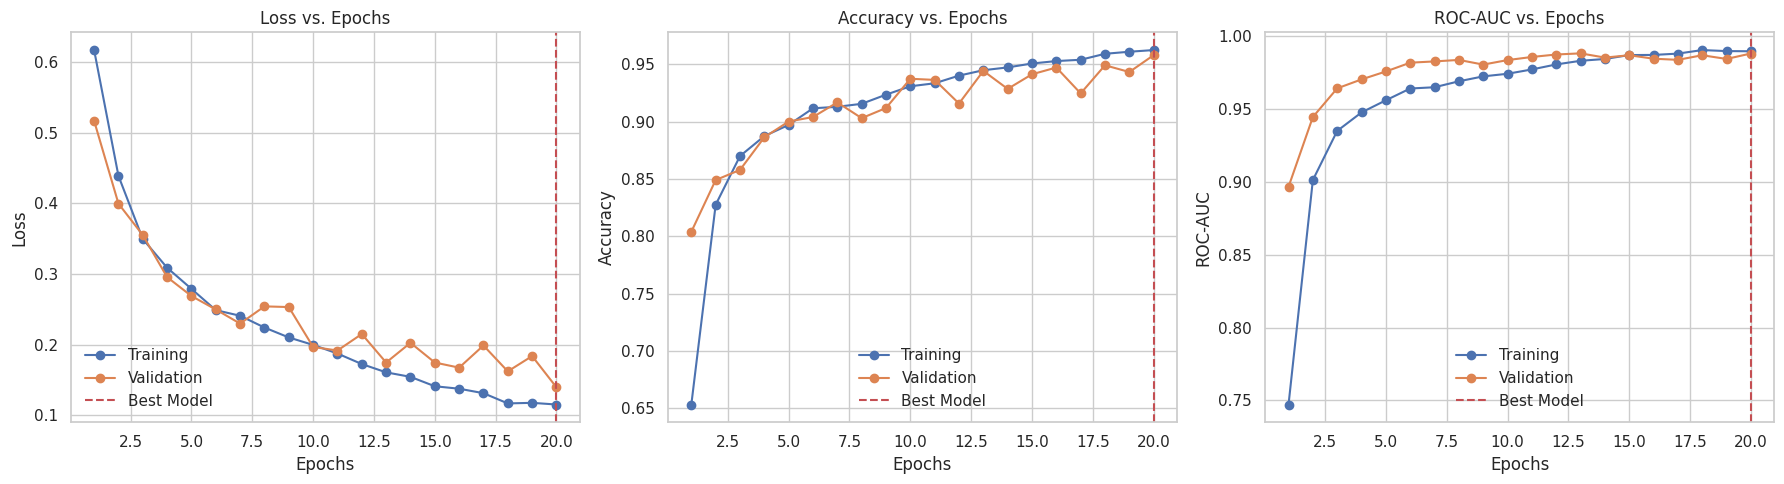

In [21]:
# Create a figure for plotting training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot loss
axes[0].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training')
axes[0].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation')
axes[0].axvline(x=best_epoch + 1, color='r', linestyle='--', label='Best Model')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs. Epochs')
axes[0].legend()
axes[0].grid(True)

# Plot accuracy
axes[1].plot(range(1, len(train_accs) + 1), train_accs, marker='o', label='Training')
axes[1].plot(range(1, len(val_accs) + 1), val_accs, marker='o', label='Validation')
axes[1].axvline(x=best_epoch + 1, color='r', linestyle='--', label='Best Model')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].legend()
axes[1].grid(True)

# Plot ROC-AUC
axes[2].plot(range(1, len(train_roc_aucs) + 1), train_roc_aucs, marker='o', label='Training')
axes[2].plot(range(1, len(val_roc_aucs) + 1), val_roc_aucs, marker='o', label='Validation')
axes[2].axvline(x=best_epoch + 1, color='r', linestyle='--', label='Best Model')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('ROC-AUC')
axes[2].set_title('ROC-AUC vs. Epochs')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'training_curves.png'))
plt.show()

## Section 10: Evaluate the Model on the Test Set

Now that we have trained our model and identified the best checkpoint, let's evaluate its performance on the unseen test set.

In [23]:
# Load the best model checkpoint
best_model_path = os.path.join(CONFIG['model_dir'], 'best_model_siamese_network.pth')
best_checkpoint = torch.load(best_model_path, map_location=CONFIG['device'], weights_only=False)

# Create a new model instance
best_model = SiameseNetwork(
    backbone_name=CONFIG['backbone'],
    pretrained=False,  # No need for pretrained weights as we're loading from checkpoint
    embedding_dim=CONFIG['embedding_dim']
)

# Load the state dict
best_model.load_state_dict(best_checkpoint['model_state_dict'])
best_model = best_model.to(CONFIG['device'])

print(f"Loaded best model from epoch {best_checkpoint['epoch']}")
print(f"Validation metrics from checkpoint - Loss: {best_checkpoint['val_loss']:.4f}, Accuracy: {best_checkpoint['val_acc']:.4f}, ROC-AUC: {best_checkpoint['val_roc_auc']:.4f}")

# Evaluate on the test set
test_loss, test_acc, test_roc_auc = validate(
    best_model, test_loader, criterion, CONFIG['device']
)

print(f"\nTest set metrics:")
print(f"Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, ROC-AUC: {test_roc_auc:.4f}")

Transfer learning mode: backbone frozen, only training embedding and similarity head
Backbone: tiny_vit_5m_224.in1k, Output dimension: 320
Training mode: transfer_learning
Loaded best model from epoch 20
Validation metrics from checkpoint - Loss: 0.1395, Accuracy: 0.9578, ROC-AUC: 0.9880


Validation:   0%|          | 0/32 [00:00<?, ?it/s]


Test set metrics:
Loss: 0.1270, Accuracy: 0.9598, ROC-AUC: 0.9893



Confusion Matrix:
[[494  16]
 [ 25 485]]


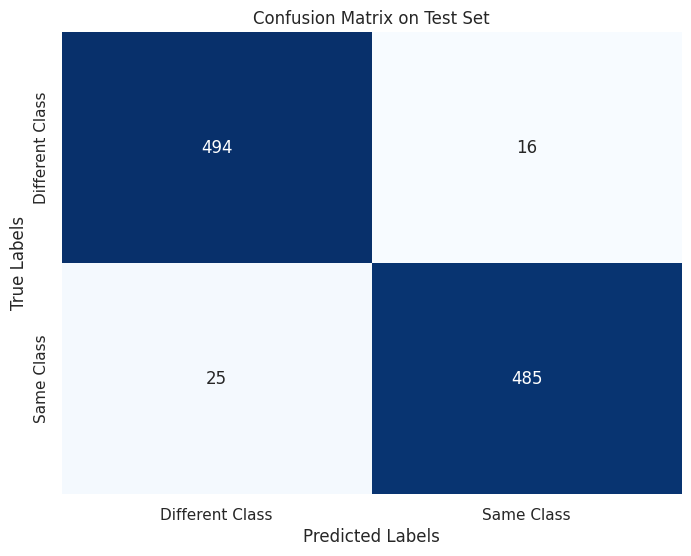


Classification Report:
                 precision    recall  f1-score   support

Different Class       0.95      0.97      0.96       510
     Same Class       0.97      0.95      0.96       510

       accuracy                           0.96      1020
      macro avg       0.96      0.96      0.96      1020
   weighted avg       0.96      0.96      0.96      1020



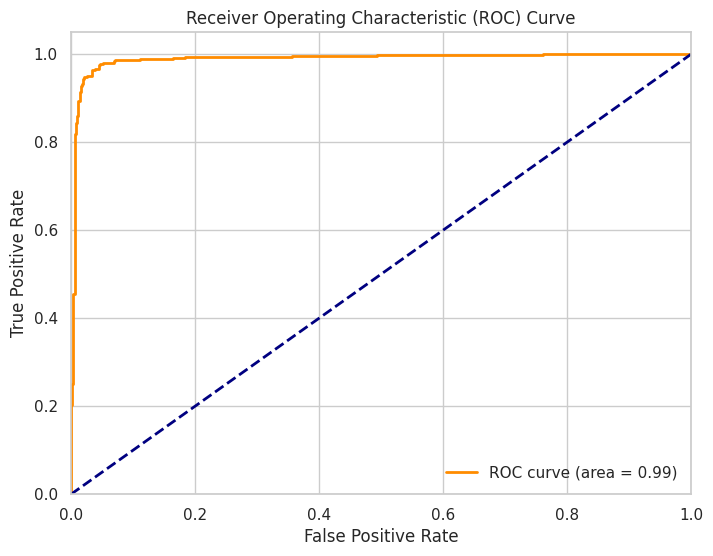

In [24]:
# Function to get all predictions and targets
def get_all_predictions(model, dataloader, device):
    """Get all predictions and targets from the dataloader."""
    model.eval()
    all_outputs = []
    all_targets = []
    all_classes = []

    with torch.no_grad():
        for (img1, img2), targets, (class1, class2) in dataloader:
            # Move data to device
            img1, img2 = img1.to(device), img2.to(device)

            # Forward pass
            outputs = model(img1, img2)

            # Store predictions, targets, and classes
            all_outputs.append(outputs.cpu())
            all_targets.append(targets)
            all_classes.append((class1, class2))

    # Concatenate results
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    all_classes1 = torch.cat([c[0] for c in all_classes])
    all_classes2 = torch.cat([c[1] for c in all_classes])

    return all_outputs, all_targets, (all_classes1, all_classes2)

# Get predictions for the test set
test_outputs, test_targets, (test_classes1, test_classes2) = get_all_predictions(
    best_model, test_loader, CONFIG['device']
)

# Convert to numpy arrays
test_preds = (test_outputs >= 0.5).float().numpy()
test_targets_np = test_targets.numpy()

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_targets_np, test_preds)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.xticks([0.5, 1.5], ['Different Class', 'Same Class'])
plt.yticks([0.5, 1.5], ['Different Class', 'Same Class'])
plt.savefig(os.path.join(CONFIG['output_dir'], 'confusion_matrix.png'))
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(test_targets_np, test_preds, target_names=['Different Class', 'Same Class']))

# Plot ROC curve
from sklearn.metrics import roc_curve, auc

# Get ROC curve
fpr, tpr, _ = roc_curve(test_targets_np, test_outputs.numpy())
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(os.path.join(CONFIG['output_dir'], 'roc_curve.png'))
plt.show()

## Section 11: Visualizing the Learned Embedding Space

To better understand what our Siamese network has learned, let's visualize the embedding space. We'll use t-SNE (t-Distributed Stochastic Neighbor Embedding) to reduce the high-dimensional embeddings to a 2D space for visualization. This will help us see if our model has learned to cluster flowers of the same class together.

Extracting embeddings for visualization...
Extracted 500 embeddings with dimension 512
Applying t-SNE dimensionality reduction...


/tmp/ipykernel_36/1673248514.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(np.unique(labels)))


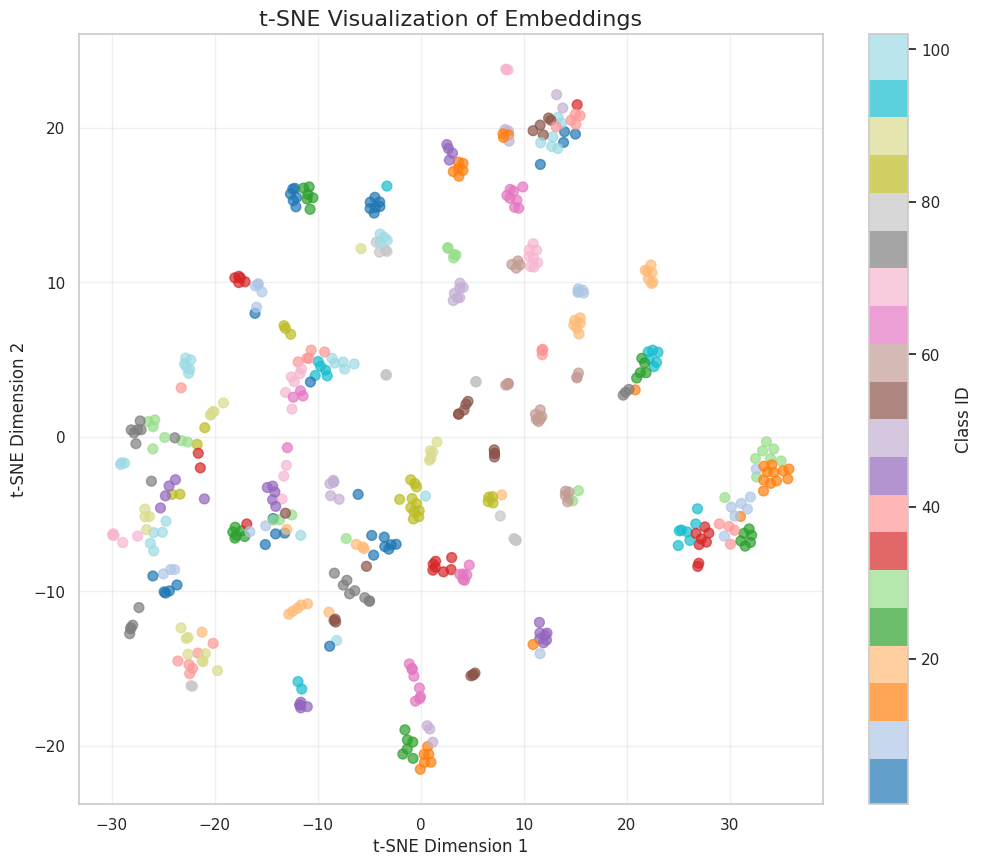

In [26]:
def extract_embeddings(model, dataloader, device):
    """Extract embeddings for all images in the dataloader."""
    model.eval()
    embeddings = []
    labels = []
    img_ids = []

    with torch.no_grad():
        for idx, (imgs, class_labels) in enumerate(dataloader):
            imgs = imgs.to(device)

            # Get embeddings
            embedding = model.get_embedding(imgs)

            # Store embeddings and labels
            embeddings.append(embedding.cpu())
            labels.append(class_labels)
            img_ids.extend([f"img_{idx * dataloader.batch_size + i}" for i in range(len(class_labels))])

    # Concatenate results
    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()

    return embeddings, labels, img_ids


# Create a new dataloader that returns one image per sample (not pairs)
# We'll use the test dataset for this visualization
from torch.utils.data import Subset

# Create a subset of the test dataset with a reasonable number of samples for visualization
test_subset_indices = np.random.choice(
    len(image_df[image_df['split'] == 'test']),
    min(500, len(image_df[image_df['split'] == 'test'])),
    replace=False
)

# Create a custom dataset class for single image extraction
class SingleImageDataset(Dataset):
    def __init__(self, df, split='test', transform=None):
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, label

# Create the dataset and dataloader
single_test_dataset = SingleImageDataset(image_df, split='test', transform=val_transform)
subset_dataset = Subset(single_test_dataset, test_subset_indices)
single_loader = DataLoader(subset_dataset, batch_size=32, shuffle=False, num_workers=4)

# Extract embeddings
print("Extracting embeddings for visualization...")
embeddings, labels, img_ids = extract_embeddings(best_model, single_loader, CONFIG['device'])
print(f"Extracted {embeddings.shape[0]} embeddings with dimension {embeddings.shape[1]}")

# Use t-SNE for dimensionality reduction
from sklearn.manifold import TSNE

print("Applying t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

# Convert to DataFrame for easier plotting
tsne_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': labels,
    'img_id': img_ids
})

# Plot the embeddings
plt.figure(figsize=(12, 10))

# Get a colormap that can handle many classes
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Use a colormap that works well with many classes
cmap = cm.get_cmap('tab20', len(np.unique(labels)))
norm = mcolors.Normalize(vmin=np.min(labels), vmax=np.max(labels))

# Create scatter plot
scatter = plt.scatter(
    tsne_df['x'], tsne_df['y'],
    c=tsne_df['label'],
    cmap=cmap,
    norm=norm,
    alpha=0.7,
    s=50
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Class ID')

# Add labels and title
plt.title('t-SNE Visualization of Embeddings', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig(os.path.join(CONFIG['output_dir'], 'tsne_embeddings.png'), dpi=300, bbox_inches='tight')
plt.show()


## Section 12: Conclusion

In this notebook, we successfully implemented a Siamese neural network for flower image similarity. Let's summarize what we've accomplished and outline potential next steps.

In [27]:
# Summarize model performance and key results
summary_metrics = {
    'test_accuracy': test_acc,
    'test_auc_roc': test_roc_auc,
    'test_loss': test_loss,
    'best_epoch': best_epoch + 1,
    'backbone': CONFIG['backbone'],
    'embedding_dim': CONFIG['embedding_dim'],
    'batch_size': CONFIG['batch_size'],
    'learning_rate': CONFIG['learning_rate']
}

# Save summary metrics to JSON
with open(os.path.join(CONFIG['output_dir'], 'model_summary.json'), 'w') as f:
    json.dump(summary_metrics, f, indent=4)

print("\nModel Summary:")
for key, value in summary_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")


Model Summary:
test_accuracy: 0.9598
test_auc_roc: 0.9893
test_loss: 0.1270
best_epoch: 20
backbone: tiny_vit_5m_224.in1k
embedding_dim: 512
batch_size: 32
learning_rate: 0.0001


Key Insights:
1. Siamese networks effectively learn similarity between flower images by comparing feature embeddings
2. The tiny_vit_5m_224.in1k backbone proved effective for extracting meaningful features from flower images
3. Class imbalance required careful consideration when generating training pairs
4. Data augmentation significantly improved model generalization and reduced overfitting
5. The embedding visualization shows clear clustering of similar flower classes
6. Element-wise product of feature embeddings provided discriminative power for similarity prediction